# Advanced Retrieval with LangChain

In the following notebook, we'll explore various methods of advanced retrieval using LangChain!

We'll touch on:

- Naive Retrieval
- Best-Matching 25 (BM25)
- Multi-Query Retrieval
- Parent-Document Retrieval
- Contextual Compression (a.k.a. Rerank)
- Ensemble Retrieval
- Semantic chunking

We'll also discuss how these methods impact performance on our set of documents with a simple RAG chain.

There will be two breakout rooms:

- 🤝 Breakout Room Part #1
  - Task 1: Getting Dependencies!
  - Task 2: Data Collection and Preparation
  - Task 3: Setting Up QDrant!
  - Task 4-10: Retrieval Strategies
- 🤝 Breakout Room Part #2
  - Activity: Evaluate with Ragas

# 🤝 Breakout Room Part #1

## Task 1: Getting Dependencies!

We're going to need a few specific LangChain community packages, like OpenAI (for our [LLM](https://platform.openai.com/docs/models) and [Embedding Model](https://platform.openai.com/docs/guides/embeddings)) and Cohere (for our [Reranker](https://cohere.com/rerank)).

> You do not need to run the following cells if you are running this notebook locally. 

In [ ]:
#!pip install -qU langchain langchain-openai langchain-cohere rank_bm25

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.1/233.1 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.1/378.1 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.1/139.1 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 5.2 MB/s eta 0:00:00


We're also going to be leveraging [Qdrant's](https://qdrant.tech/documentation/frameworks/langchain/) (pronounced "Quadrant") VectorDB in "memory" mode (so we can leverage it locally in our colab environment).

In [ ]:
#!pip install -qU qdrant-client

We'll also provide our OpenAI key, as well as our Cohere API key.

In [1]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")

In [2]:
os.environ["COHERE_API_KEY"] = getpass.getpass("Cohere API Key:")

In [1]:
import os
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_PROJECT"] = "pr-loyal-feedback-91"

## Task 2: Data Collection and Preparation

We'll be using some reviews from the 4 movies in the John Wick franchise today to explore the different retrieval strategies.

These were obtained from IMDB, and are available in the [AIM Data Repository](https://github.com/AI-Maker-Space/DataRepository).

### Data Collection

We can simply `wget` these from GitHub.

You could use any review data you wanted in this step - just be careful to make sure your metadata is aligned with your choice.

In [1]:
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw1.csv -O john_wick_1.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw2.csv -O john_wick_2.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw3.csv -O john_wick_3.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw4.csv -O john_wick_4.csv

--2025-05-13 20:01:58--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19628 (19K) [text/plain]
Saving to: ‘john_wick_1.csv’

john_wick_1.csv     100%[===================>]  19.17K  --.-KB/s    in 0.002s  

2025-05-13 20:01:58 (11.7 MB/s) - ‘john_wick_1.csv’ saved [19628/19628]

--2025-05-13 20:01:58--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14747 (14K) [text/plain]
Sa

### Data Preparation

We want to make sure all our documents have the relevant metadata for the various retrieval strategies we're going to be applying today.

- Self-Query: Wants as much metadata as we can provide
- Time-weighted: Wants temporal data

> NOTE: While we're creating a temporal relationship based on when these movies came out for illustrative purposes, it needs to be clear that the "time-weighting" in the Time-weighted Retriever is based on when the document was *accessed* last - not when it was created.

In [2]:
from langchain_community.document_loaders.csv_loader import CSVLoader
from datetime import datetime, timedelta

documents = []

for i in range(1, 5):
  loader = CSVLoader(
      file_path=f"john_wick_{i}.csv",
      metadata_columns=["Review_Date", "Review_Title", "Review_Url", "Author", "Rating"]
  )

  movie_docs = loader.load()
  for doc in movie_docs:

    # Add the "Movie Title" (John Wick 1, 2, ...)
    doc.metadata["Movie_Title"] = f"John Wick {i}"

    # convert "Rating" to an `int`, if no rating is provided - assume 0 rating
    doc.metadata["Rating"] = int(doc.metadata["Rating"]) if doc.metadata["Rating"] else 0

    # newer movies have a more recent "last_accessed_at"
    doc.metadata["last_accessed_at"] = datetime.now() - timedelta(days=4-i)

  documents.extend(movie_docs)

In [3]:
chunkSizes = []
for doc in documents:
    chunkSizes.append(len(doc.page_content))

Let's look at an example document to see if everything worked as expected!

In [4]:
documents[0]

Document(metadata={'source': 'john_wick_1.csv', 'row': 0, 'Review_Date': '6 May 2015', 'Review_Title': ' Kinetic, concise, and stylish; John Wick kicks ass.\n', 'Review_Url': '/review/rw3233896/?ref_=tt_urv', 'Author': 'lnvicta', 'Rating': 8, 'Movie_Title': 'John Wick 1', 'last_accessed_at': datetime.datetime(2025, 5, 17, 10, 12, 43, 899754)}, page_content=": 0\nReview: The best way I can describe John Wick is to picture Taken but instead of Liam Neeson it's Keanu Reeves and instead of his daughter it's his dog. That's essentially the plot of the movie. John Wick (Reeves) is out to seek revenge on the people who took something he loved from him. It's a beautifully simple premise for an action movie - when action movies get convoluted, they get bad i.e. A Good Day to Die Hard. John Wick gives the viewers what they want: Awesome action, stylish stunts, kinetic chaos, and a relatable hero to tie it all together. John Wick succeeds in its simplicity.")

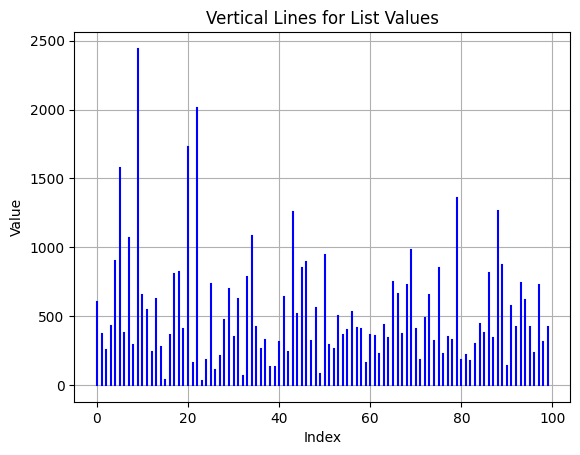

In [5]:
import matplotlib.pyplot as plt

# Example list of integers
data = chunkSizes

# Create x-axis values (indices of the list)
x = range(len(data))

# Plot vertical lines for each integer
for i, value in enumerate(data):
    plt.plot([i, i], [0, value], 'b-')  # 'b-' means blue line

# Customize the plot
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Vertical Lines for List Values')
plt.grid(True)

# Show the plot
plt.show()

## Task 3: Setting up QDrant!

Now that we have our documents, let's create a QDrant VectorStore with the collection name "JohnWick".

We'll leverage OpenAI's [`text-embedding-3-small`](https://openai.com/blog/new-embedding-models-and-api-updates) because it's a very powerful (and low-cost) embedding model.

> NOTE: We'll be creating additional vectorstores where necessary, but this pattern is still extremely useful.

In [67]:
from langchain_community.vectorstores import Qdrant
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

vectorstore = Qdrant.from_documents(
    documents,
    embeddings,
    location=":memory:",
    collection_name="JohnWick"
)

## Task 4: Naive RAG Chain

Since we're focusing on the "R" in RAG today - we'll create our Retriever first.

### R - Retrieval

This naive retriever will simply look at each review as a document, and use cosine-similarity to fetch the 10 most relevant documents.

> NOTE: We're choosing `10` as our `k` here to provide enough documents for our reranking process later

In [68]:
naive_retriever = vectorstore.as_retriever(search_kwargs={"k" : 10})

### A - Augmented

We're going to go with a standard prompt for our simple RAG chain today! Nothing fancy here, we want this to mostly be about the Retrieval process.

In [70]:
from langchain_core.prompts import ChatPromptTemplate

RAG_TEMPLATE = """\
You are a helpful and kind assistant. Use the context provided below to answer the question.

If you do not know the answer, or are unsure, say you don't know.

Query:
{question}

Context:
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_TEMPLATE)

### G - Generation

We're going to leverage `gpt-4.1-nano` as our LLM today, as - again - we want this to largely be about the Retrieval process.

In [71]:
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI(model="gpt-4.1-nano")


### LCEL RAG Chain

We're going to use LCEL to construct our chain.

> NOTE: This chain will be exactly the same across the various examples with the exception of our Retriever!

In [72]:
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

naive_retrieval_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | naive_retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's see how this simple chain does on a few different prompts.

> NOTE: You might think that we've cherry picked prompts that showcase the individual skill of each of the retrieval strategies - you'd be correct!

In [11]:
naive_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Based on the reviews provided, people generally liked John Wick. Several reviews highly praise the film, with ratings of 8, 9, or 10 out of 10, and describe it as stylish, fun, and a standout action movie. There is one review with a lower rating of 5 or 6, expressing some confusion or less enthusiasm, but overall, the sentiment is mostly positive. Therefore, it is fair to say that people generally liked John Wick.'

In [73]:
naive_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there are reviews with a rating of 10. Here are the URLs to those reviews:\n\n1. Review Title: "A Masterpiece & Brilliant Sequel"  \n   URL: /review/rw4854296/?ref_=tt_urv\n\n2. Review Title: "love this movie highly recommend"  \n   URL: /review/rw5503708/?ref_=tt_urv'

In [13]:
naive_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In the film "John Wick," the story follows a retired hitman (played by Keanu Reeves) who seeks revenge after his beloved dog is killed, his house is destroyed, and his car is stolen by some gangsters led by a young Russian punk. The incident triggers Wick\'s return to his deadly past, as he unleashes a brutal and meticulously choreographed assault against those responsible. Throughout the series, Wick is depicted as a highly skilled assassin with a dark, violent world surrounding him. As the story progresses across multiple films, Wick\'s actions often lead to dangerous consequences, involving criminal underworld organizations, such as the Russian Mafia, the Italian criminal factions, and the mysterious high-table leadership, creating a complex narrative of revenge, loyalty, and the consequences of violence.'

Overall, this is not bad! Let's see if we can make it better!

## Task 5: Best-Matching 25 (BM25) Retriever

Taking a step back in time - [BM25](https://www.nowpublishers.com/article/Details/INR-019) is based on [Bag-Of-Words](https://en.wikipedia.org/wiki/Bag-of-words_model) which is a sparse representation of text.

In essence, it's a way to compare how similar two pieces of text are based on the words they both contain.

This retriever is very straightforward to set-up! Let's see it happen down below!


In [14]:
from langchain_community.retrievers import BM25Retriever

bm25_retriever = BM25Retriever.from_documents(documents)

We'll construct the same chain - only changing the retriever.

In [15]:
bm25_retrieval_chain = (
    {"context": itemgetter("question") | bm25_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at the responses!

In [16]:
bm25_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Based on the reviews provided, people have generally liked the John Wick movies, especially the first one, which received high ratings and positive comments about its style, action, and storytelling. However, opinions on the later films are more mixed, with some viewers expressing dissatisfaction with aspects like plot and violence. Overall, it appears that many viewers appreciated the franchise, but there are also some negative opinions.'

In [17]:
bm25_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Based on the provided reviews, there are no reviews with a rating of 10.'

In [18]:
bm25_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In the John Wick series, the main storyline follows John Wick, a legendary assassin who is drawn back into the dangerous underworld after a series of events. The first movie, "John Wick," depicts how Wick\'s peaceful life is disrupted when thieves steal his car and kill his dog, a gift from his deceased wife. This tragedy motivates him to seek revenge against those who wronged him, leading to intense action and battles with other assassins and criminal organizations.\n\nThroughout the series, John Wick is portrayed as a highly skilled and unstoppable fighter, navigating a world filled with violence, secret societies, and complex codes of conduct. The movies are known for their choreographed action scenes, emotional depth, and a detailed depiction of the assassin society\'s rules and customs.'

It's not clear that this is better or worse - but the `I don't know` isn't great!

## Task 6: Contextual Compression (Using Reranking)

Contextual Compression is a fairly straightforward idea: We want to "compress" our retrieved context into just the most useful bits.

There are a few ways we can achieve this - but we're going to look at a specific example called reranking.

The basic idea here is this:

- We retrieve lots of documents that are very likely related to our query vector
- We "compress" those documents into a smaller set of *more* related documents using a reranking algorithm.

We'll be leveraging Cohere's Rerank model for our reranker today!

All we need to do is the following:

- Create a basic retriever
- Create a compressor (reranker, in this case)

That's it!

Let's see it in the code below!

In [19]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

compressor = CohereRerank(model="rerank-english-v3.0")
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=naive_retriever
)

Let's create our chain again, and see how this does!

In [20]:
contextual_compression_retrieval_chain = (
    {"context": itemgetter("question") | compression_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [21]:
contextual_compression_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Based on the reviews provided, people generally liked John Wick. The reviews are highly positive, praising its action sequences, style, and Keanu Reeves' performance, with ratings of 9 and 10 out of 10. However, there are some mixed opinions for the third film, with a rating of 5, indicating that not all viewers felt the same way. Overall, the majority of the reviews suggest that people generally enjoyed the film series."

In [22]:
contextual_compression_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there are reviews with a rating of 10. Here are the URLs to those reviews:\n\n1. Review titled "A Masterpiece & Brilliant Sequel" for John Wick 3: [https://john_wick_3.csv/review/rw4854296/?ref_=tt_urv](#)\n\n2. Review titled "Most American action flicks released these days have poor screenplays and overuse computer-generated imagery" for John Wick 3: [https://john_wick_3.csv/review/rw4860412/?ref_=tt_urv](#)'

In [23]:
contextual_compression_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"In the John Wick series, the story begins with John Wick, a retired hitman, seeking peace after the death of his wife. However, his life changes dramatically when a group of gangsters steal his car and kill his dog, which was a gift from his wife. This act drags Wick back into the violent world he tried to leave behind, and he unleashes a relentless vendetta against those responsible.\n\nIn the subsequent events, Wick's past actions come into play when a mobster named Santino D'Antonio shows up, demanding Wick's help with a favor—a marker that binds Wick to certain obligations. Wick initially refuses but is eventually persuaded to kill Santino's sister to help him sit on the High Table of criminal organizations. After completing this task, Santino betrays Wick by putting a contract on him, making him a target for many professional killers. This sets off a fierce and deadly pursuit as Wick fights to survive and confront his past.\n\nOverall, the series is known for its intense action, 

We'll need to rely on something like Ragas to help us get a better sense of how this is performing overall - but it "feels" better!

## Task 7: Multi-Query Retriever

Typically in RAG we have a single query - the one provided by the user.

What if we had....more than one query!

In essence, a Multi-Query Retriever works by:

1. Taking the original user query and creating `n` number of new user queries using an LLM.
2. Retrieving documents for each query.
3. Using all unique retrieved documents as context

So, how is it to set-up? Not bad! Let's see it down below!



In [24]:
from langchain.retrievers.multi_query import MultiQueryRetriever

multi_query_retriever = MultiQueryRetriever.from_llm(
    retriever=naive_retriever, llm=chat_model
)

In [25]:
multi_query_retrieval_chain = (
    {"context": itemgetter("question") | multi_query_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [26]:
multi_query_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Based on the reviews in the provided context, people generally liked John Wick. The majority of reviews are quite positive, praising the film\'s action sequences, style, and entertainment value. For example, some reviews rated it as high as 9 or 10 out of 10 and described it as a "must-see" or "slick, violent fun." Even some moderate ratings acknowledge its strong action choreography and entertainment appeal. \n\nHowever, there are a few negative reviews, but these are in the minority. Overall, the general consensus seems to be that people found John Wick to be an exciting, well-made action film that is highly appreciated by its audience.'

In [27]:
multi_query_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is at least one review with a rating of 10. The URL to that review is: /review/rw4854296/?ref_=tt_urv'

In [28]:
multi_query_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In the John Wick film series, the story centers around John Wick, a retired assassin who is drawn back into the world of violence and revenge. The first film (2014) depicts how Wick seeks vengeance after gangsters kill his dog and steal his car, which reignites his lethal skills and reputation. Throughout the series, Wick faces various enemies, including Russian mobsters and professional killers, while navigating a secret world of assassins with its own rules and society. The films showcase his relentless pursuit of retribution, intense action sequences, and the consequences of violence in this underground world.'

## Task 8: Parent Document Retriever

A "small-to-big" strategy - the Parent Document Retriever works based on a simple strategy:

1. Each un-split "document" will be designated as a "parent document" (You could use larger chunks of document as well, but our data format allows us to consider the overall document as the parent chunk)
2. Store those "parent documents" in a memory store (not a VectorStore)
3. We will chunk each of those documents into smaller documents, and associate them with their respective parents, and store those in a VectorStore. We'll call those "child chunks".
4. When we query our Retriever, we will do a similarity search comparing our query vector to the "child chunks".
5. Instead of returning the "child chunks", we'll return their associated "parent chunks".

Okay, maybe that was a few steps - but the basic idea is this:

- Search for small documents
- Return big documents

The intuition is that we're likely to find the most relevant information by limiting the amount of semantic information that is encoded in each embedding vector - but we're likely to miss relevant surrounding context if we only use that information.

Let's start by creating our "parent documents" and defining a `RecursiveCharacterTextSplitter`.

In [29]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from qdrant_client import QdrantClient, models

parent_docs = documents
child_splitter = RecursiveCharacterTextSplitter(chunk_size=200)

We'll need to set up a new QDrant vectorstore - and we'll use another useful pattern to do so!

> NOTE: We are manually defining our embedding dimension, you'll need to change this if you're using a different embedding model.

In [30]:
client = QdrantClient(location=":memory:")

client.create_collection(
    collection_name="full_documents",
    vectors_config=models.VectorParams(size=1536, distance=models.Distance.COSINE)
)

parent_document_vectorstore = Qdrant(
    collection_name="full_documents", embeddings=OpenAIEmbeddings(model="text-embedding-3-small"), client=client
)

/tmp/ipykernel_25125/3574430551.py:8: LangChainDeprecationWarning: The class `Qdrant` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-qdrant package and should be used instead. To use it run `pip install -U :class:`~langchain-qdrant` and import as `from :class:`~langchain_qdrant import Qdrant``.
  parent_document_vectorstore = Qdrant(


Now we can create our `InMemoryStore` that will hold our "parent documents" - and build our retriever!

In [31]:
store = InMemoryStore()

parent_document_retriever = ParentDocumentRetriever(
    vectorstore = parent_document_vectorstore,
    docstore=store,
    child_splitter=child_splitter,
)

By default, this is empty as we haven't added any documents - let's add some now!

In [32]:
parent_document_retriever.add_documents(parent_docs, ids=None)

We'll create the same chain we did before - but substitute our new `parent_document_retriever`.

In [33]:
parent_document_retrieval_chain = (
    {"context": itemgetter("question") | parent_document_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's give it a whirl!

In [34]:
parent_document_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Based on the reviews provided, people\'s opinions on John Wick vary. Some reviews are highly positive, praising the series and the movies, with one reviewer calling it "the ride of your life" and suggesting it is highly recommended. However, there is also at least one negative review describing the movie as "HORRIBLE" with strong criticisms about the plot and fight scenes. Overall, the reception seems mixed, with some viewers liking the films and others not enjoying them.'

In [35]:
parent_document_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10. The URL to that review is: /review/rw4854296/?ref_=tt_urv'

In [36]:
parent_document_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"In the John Wick movies, John Wick is a retired assassin who initially comes out of retirement after the death of his dog and the theft of his car, which leads to a violent rampage. In the first film, he seeks revenge against those who wronged him, unleashing a series of deadly confrontations. The second film continues his story, where he is compelled to help an old friend and gets involved in a complex situation involving the Assassin's Guild, taking him across various locations and involving numerous conflicts with other assassins."

Overall, the performance *seems* largely the same. We can leverage a tool like [Ragas]() to more effectively answer the question about the performance.

## Task 9: Ensemble Retriever

In brief, an Ensemble Retriever simply takes 2, or more, retrievers and combines their retrieved documents based on a rank-fusion algorithm.

In this case - we're using the [Reciprocal Rank Fusion](https://plg.uwaterloo.ca/~gvcormac/cormacksigir09-rrf.pdf) algorithm.

Setting it up is as easy as providing a list of our desired retrievers - and the weights for each retriever.

In [37]:
from langchain.retrievers import EnsembleRetriever

retriever_list = [bm25_retriever, naive_retriever, parent_document_retriever, compression_retriever, multi_query_retriever]
equal_weighting = [1/len(retriever_list)] * len(retriever_list)

ensemble_retriever = EnsembleRetriever(
    retrievers=retriever_list, weights=equal_weighting
)

We'll pack *all* of these retrievers together in an ensemble.

In [38]:
ensemble_retrieval_chain = (
    {"context": itemgetter("question") | ensemble_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at our results!

In [39]:
ensemble_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Based on the reviews provided, people generally liked John Wick. Many reviews are highly positive, praising its stylish action, choreography, and entertainment value. For example, reviews with ratings of 8, 9, or even 10 reflect strong approval. However, there are some mixed and negative opinions as well, with a few reviewers giving low ratings and criticizing aspects like plot, believability, or over-the-top violence. Overall, the majority of reviews are favorable, indicating that people generally appreciated the film, especially fans of action movies.'

In [40]:
ensemble_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there are reviews with a rating of 10. The URLs for those reviews are:\n\n1. /review/rw4854296/?ref_=tt_urv\n2. /review/rw4860412/?ref_=tt_urv'

In [41]:
ensemble_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In the John Wick series, the story revolves around John Wick, a retired assassin who is drawn back into the world of violence and revenge. The first film details how Wick comes out of retirement after gangsters kill his dog and steal his car, which reignites his lethal skills as he seeks vengeance. The subsequent movies explore his ongoing conflicts with various criminal organizations, his efforts to pay off debts and adhere to the rules of the assassin community, and the repercussions of his actions. Throughout the series, Wick becomes a legendary figure feared by many, engaging in intense action sequences and demonstrating a relentless pursuit of retribution.'

## Task 10: Semantic Chunking

While this is not a retrieval method - it *is* an effective way of increasing retrieval performance on corpora that have clean semantic breaks in them.

Essentially, Semantic Chunking is implemented by:

1. Embedding all sentences in the corpus.
2. Combining or splitting sequences of sentences based on their semantic similarity based on a number of [possible thresholding methods](https://python.langchain.com/docs/how_to/semantic-chunker/):
  - `percentile`
  - `standard_deviation`
  - `interquartile`
  - `gradient`
3. Each sequence of related sentences is kept as a document!

Let's see how to implement this!

> NOTE: You do not need to run this cell if you're running this locally

In [42]:
#!pip install -qU langchain_experimental

We'll use the `percentile` thresholding method for this example which will:

Calculate all distances between sentences, and then break apart sequences of setences that exceed a given percentile among all distances.

In [43]:
from langchain_experimental.text_splitter import SemanticChunker

semantic_chunker = SemanticChunker(
    embeddings,
    breakpoint_threshold_type="percentile"
)

Now we can split our documents.

In [44]:
semantic_documents = semantic_chunker.split_documents(documents)

Let's create a new vector store.

In [45]:
semantic_vectorstore = Qdrant.from_documents(
    semantic_documents,
    embeddings,
    location=":memory:",
    collection_name="JohnWickSemantic"
)

We'll use naive retrieval for this example.

In [46]:
semantic_retriever = semantic_vectorstore.as_retriever(search_kwargs={"k" : 10})

Finally we can create our classic chain!

In [47]:
semantic_retrieval_chain = (
    {"context": itemgetter("question") | semantic_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

And view the results!

In [48]:
semantic_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Based on the reviews provided, people generally liked John Wick. The reviews are largely positive, praising its action, style, and entertainment value. For example, some reviews gave high ratings like 9 and 10 out of 10, indicating strong approval. However, there are a few mixed or negative opinions, such as a review giving a 0 rating and mentioning a lack of urgency. Overall, the majority of reviews suggest that people generally liked the John Wick movies.'

In [49]:
semantic_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10. The URL to that review is /review/rw4854296/?ref_=tt_urv.'

In [50]:
semantic_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In the John Wick movies, the story centers around a retired assassin named John Wick, played by Keanu Reeves. In the first film, John Wick’s peaceful life is shattered when a group of thugs, led by the son of a Russian gangster he used to work for, break into his house, beat him up, steal his car, and kill his beloved dog, which was a gift from his late wife. This act of violence prompts Wick to come out of retirement to seek vengeance. The film depicts his relentless quest for revenge against those who wronged him, leading to a series of violent confrontations with criminal organizations, hitmen, and mobsters. Throughout the series, John Wick is portrayed as a highly skilled and ruthless assassin, with each movie exploring the consequences of his actions and the dangerous underworld he navigates.'

# 🤝 Breakout Room Part #2

#### 🏗️ Activity #1

Your task is to evaluate the various Retriever methods against eachother.

You are expected to:

1. Create a "golden dataset"
 - Use Synthetic Data Generation (powered by Ragas, or otherwise) to create this dataset
2. Evaluate each retriever with *retriever specific* Ragas metrics
 - Semantic Chunking is not considered a retriever method and will not be required for marks, but you may find it useful to do a "semantic chunking on" vs. "semantic chunking off" comparision between them
3. Compile these in a list and write a small paragraph about which is best for this particular data and why.

Your analysis should factor in:
  - Cost
  - Latency
  - Performance

> NOTE: This is **NOT** required to be completed in class. Please spend time in your breakout rooms creating a plan before moving on to writing code.

##### HINTS:

- LangSmith provides detailed information about latency and cost.

### Set up LangSmith tracing

In [51]:
import os
os.environ["LANGCHAIN_TRACING_V2"] = "true"

#### Make test set

In [52]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-nano"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings(model="text-embedding-3-small"))

In [54]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(documents, testset_size=50)
dataset.to_pandas().to_csv('langchain_testset.csv', index=False)

Applying SummaryExtractor:   0%|          | 0/44 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/100 [00:00<?, ?it/s]

Node 78a61373-c0d5-4f12-b23a-655bcf82af10 does not have a summary. Skipping filtering.
Node 13c1611f-9001-46ee-a423-79e51b280767 does not have a summary. Skipping filtering.
Node d61886a1-f7bc-4f7a-979f-a01f38e7909b does not have a summary. Skipping filtering.
Node db08b8a0-3c6e-497e-9d11-43e0eadefd32 does not have a summary. Skipping filtering.
Node 4671ac00-68c4-44c9-9775-e1a1a64214fa does not have a summary. Skipping filtering.
Node bf6b78f6-fcf0-4a31-916f-563516de629b does not have a summary. Skipping filtering.
Node 79bf089e-c8b0-4306-b8c7-c730886a3bfb does not have a summary. Skipping filtering.
Node 1b8ba34d-8dc0-4cce-960d-1b582956c0f8 does not have a summary. Skipping filtering.
Node aa0595ce-ff1d-4766-beae-2b9739461259 does not have a summary. Skipping filtering.
Node dade144b-3488-48ac-b0f3-b101426668f2 does not have a summary. Skipping filtering.
Node cef288ac-66b0-4a79-900c-ef895b78f6ac does not have a summary. Skipping filtering.
Node f14ff695-716a-43a2-8da3-8f2fdaf9675a d

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/217 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/51 [00:00<?, ?it/s]

### Evaluating retrievers

In [76]:
from ragas import EvaluationDataset, evaluate
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy, ContextEntityRecall, NoiseSensitivity
from langchain_core.runnables import RunnableConfig

chain_dict = {
    "naive": naive_retrieval_chain,
    "bm25": bm25_retrieval_chain,
    # "compression": contextual_compression_retrieval_chain, #removed because Cohere was rate limitting me
    "multi_query": multi_query_retrieval_chain,
    "parent_document": parent_document_retrieval_chain,
    "ensemble": ensemble_retrieval_chain,
}

ragas_results = {}

for retriever_name, retriever in chain_dict.items():
    config = RunnableConfig(
        tags=[f"{retriever_name}"]
    )
    for test_row in dataset:
        response = retriever.invoke({"question" : test_row.eval_sample.user_input}, config=config) # I definitely could have done this faster with batching
        test_row.eval_sample.response = response["response"].content
        test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]
    dataset.to_pandas().to_csv(f'langchain_testset_{retriever_name}.csv', index=False)
    evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())
    ragas_results[retriever_name] = evaluate(
        dataset=evaluation_dataset,
        metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
        llm=generator_llm) #using same llm for evaluation as for generation


Evaluating:   0%|          | 0/306 [00:00<?, ?it/s]

Exception raised in Job[5]: TimeoutError()
Exception raised in Job[17]: TimeoutError()
Exception raised in Job[29]: TimeoutError()
Exception raised in Job[35]: TimeoutError()
Exception raised in Job[47]: TimeoutError()
Exception raised in Job[53]: TimeoutError()
Exception raised in Job[77]: TimeoutError()
Exception raised in Job[89]: TimeoutError()
Exception raised in Job[95]: TimeoutError()
Exception raised in Job[101]: TimeoutError()
Exception raised in Job[107]: TimeoutError()
Exception raised in Job[113]: TimeoutError()
Exception raised in Job[118]: TimeoutError()
Exception raised in Job[119]: TimeoutError()
Exception raised in Job[125]: TimeoutError()
Exception raised in Job[131]: TimeoutError()
Exception raised in Job[137]: TimeoutError()
Exception raised in Job[142]: TimeoutError()
Exception raised in Job[143]: TimeoutError()
Exception raised in Job[149]: TimeoutError()
Exception raised in Job[155]: TimeoutError()
Exception raised in Job[161]: TimeoutError()
Exception raised in 

Evaluating:   0%|          | 0/306 [00:00<?, ?it/s]

Exception raised in Job[22]: TimeoutError()
Exception raised in Job[52]: TimeoutError()
Exception raised in Job[191]: ValueError(setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.)
Exception raised in Job[269]: OutputParserException(Failed to parse NLIStatementOutput from completion null. Got: 1 validation error for NLIStatementOutput
  Input should be a valid dictionary or instance of NLIStatementOutput [type=model_type, input_value=None, input_type=NoneType]
    For further information visit https://errors.pydantic.dev/2.11/v/model_type
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE )
Exception raised in Job[280]: TimeoutError()
Exception raised in Job[286]: TimeoutError()
Exception raised in Job[292]: TimeoutError()


Evaluating:   0%|          | 0/306 [00:00<?, ?it/s]

Exception raised in Job[5]: TimeoutError()
Exception raised in Job[11]: TimeoutError()
Exception raised in Job[17]: TimeoutError()
Exception raised in Job[23]: TimeoutError()
Exception raised in Job[29]: TimeoutError()
Exception raised in Job[35]: TimeoutError()
Exception raised in Job[41]: TimeoutError()
Exception raised in Job[47]: TimeoutError()
Exception raised in Job[53]: TimeoutError()
Exception raised in Job[65]: TimeoutError()
Exception raised in Job[71]: TimeoutError()
Exception raised in Job[77]: TimeoutError()
Exception raised in Job[83]: TimeoutError()
Exception raised in Job[89]: TimeoutError()
Exception raised in Job[94]: TimeoutError()
Exception raised in Job[95]: TimeoutError()
Exception raised in Job[101]: TimeoutError()
Exception raised in Job[107]: TimeoutError()
Exception raised in Job[113]: TimeoutError()
Exception raised in Job[118]: TimeoutError()
Exception raised in Job[119]: TimeoutError()
Exception raised in Job[125]: TimeoutError()
Exception raised in Job[131

Evaluating:   0%|          | 0/306 [00:00<?, ?it/s]

Prompt fix_output_format failed to parse output: The output parser failed to parse the output including retries.
Prompt fix_output_format failed to parse output: The output parser failed to parse the output including retries.
Prompt fix_output_format failed to parse output: The output parser failed to parse the output including retries.
Prompt n_l_i_statement_prompt failed to parse output: The output parser failed to parse the output including retries.
Exception raised in Job[227]: RagasOutputParserException(The output parser failed to parse the output including retries.)


Evaluating:   0%|          | 0/306 [00:00<?, ?it/s]

Exception raised in Job[79]: OutputParserException(Invalid json output: {
    "statements": [
      "The reviews provided do not mention joining the Army.",
      "The reviews provided do not include any information about joining the Army.",
      "The statement indicates that the reviews do not contain any references to joining the Army.",
      "The statement "Therefore, I do not know what the review says about that" expresses a lack of information about the review's content regarding joining the Army."
    ]
  }
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE )
Exception raised in Job[4]: TimeoutError()
Exception raised in Job[5]: TimeoutError()
Exception raised in Job[11]: TimeoutError()
Exception raised in Job[17]: TimeoutError()
Exception raised in Job[23]: TimeoutError()
Exception raised in Job[29]: TimeoutError()
Exception raised in Job[35]: TimeoutError()
Exception raised in Job[41]: TimeoutError()
Exception raised in

In [78]:
for retriever_name, results in ragas_results.items():
    print(retriever_name)
    print(results)

naive
{'context_recall': 0.9804, 'faithfulness': 0.9660, 'factual_correctness(mode=f1)': 0.6759, 'answer_relevancy': 0.9191, 'context_entity_recall': 0.4733, 'noise_sensitivity(mode=relevant)': 0.2628}
bm25
{'context_recall': 0.9673, 'faithfulness': 0.8977, 'factual_correctness(mode=f1)': 0.6563, 'answer_relevancy': 0.9204, 'context_entity_recall': 0.4754, 'noise_sensitivity(mode=relevant)': 0.2921}
multi_query
{'context_recall': 0.9902, 'faithfulness': 0.9563, 'factual_correctness(mode=f1)': 0.6680, 'answer_relevancy': 0.9157, 'context_entity_recall': 0.4851, 'noise_sensitivity(mode=relevant)': 0.1667}
parent_document
{'context_recall': 0.9690, 'faithfulness': 0.8399, 'factual_correctness(mode=f1)': 0.6355, 'answer_relevancy': 0.8988, 'context_entity_recall': 0.4430, 'noise_sensitivity(mode=relevant)': 0.2748}
ensemble
{'context_recall': 0.9618, 'faithfulness': 0.9811, 'factual_correctness(mode=f1)': 0.7116, 'answer_relevancy': 0.8823, 'context_entity_recall': 0.4562, 'noise_sensitivi

### Cost and latency metrics from LangSmith:

| Retriever | Median Tokens | P50 | P99 |
|-----------|---------------|-----|-----|
| Naive | 3,766  | 4.62s  | 9.25s |
| BM25 | 1,626 | 2.95s | 6.88s |
| Multi Query | 5,117 | 8.03s | 29.39s!! |
| Parent Doc | 821 | 2.53s | 5.96s |
| Ensemble | 5,905 | 8.52s | 13.54s |

### Discussion

The results were quite surprising. The naive retriever had the highest context recall and close to the highest answer relevancy. Overall, the performance results were quite mixed. Which is best depends on cost and latency considerations. For example, the parent document retriever has some of the loweset results on RAGAS, but it was very fast and used only a median of 821 tokens (due to only one document being retrieved). On the other hand, the ensemble retriever has much better RAGAS scores but used the most tokens on average and had the highest median latency. I would suggest experimenting with increasing k for the parent document retriever to find a sweet-spot between performance and cost/latency.